In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
%matplotlib inline

In [2]:
import ed_conserve

In [3]:
# part a)
H = ed_conserve.calc_H(10, 1., 0.1)
Es = []
for qn in H:
    Es.append(scipy.sparse.linalg.eigsh(H[qn], which='SA', return_eigenvectors=False))
E_gs = np.min(Es)
print(E_gs)
assert abs(E_gs - -10.0250156642343) < 1.e-12

Generating Hamiltonian ... done
-10.025015664234328


In [4]:
print("explaining the bitwise operations")

N = 8
def r(s):
    "return the binary representation of s as a string, looking at N sites."
    return bin(s)[2:].zfill(N)
print(r(2))

s = 13
t = 1
print(s, " = ", r(s))
print(t, " = ", r(t))

print(r(s), "| ", r(t), " = ", r(s | t))
print(r(s), "& ", r(t), " = ", r(s & t))
print(r(s), "^ ", r(t), " = ", r(s ^ t))
print(r(s), ">>", t, " = ", r(s >> t))
print(r(s), "<<", t, " = ", r(s << t))
# extracting a single bit:
# if t has only a single bit being 1, appling s & t gives a non-zero value (= True) if this bit is 1 in s
if (s & t) :
    print( "bit is 1")

print(r(s >> 1))  # drops the bit on the very right
print(r((s& 1)<<(N-1)))  # extract the bit on the very right with &, and shift it to the left
print(r(s >> 1 | ((s& 1)<<(N-1))))  # combine them with a bitwise or
if s & 1:
    result = s >> 1 + 2 **N
else:
    result = s >> 1

explaining the bitwise operations
00000010
13  =  00001101
1  =  00000001
00001101 |  00000001  =  00001101
00001101 &  00000001  =  00000001
00001101 ^  00000001  =  00001100
00001101 >> 1  =  00000110
00001101 << 1  =  00011010
bit is 1
00000110
10000000
10000110


In [5]:
# part b)
def translate(s, N):
    return s >> 1 | (( s & 1 ) << (N-1))

In [6]:
# run a short check: test all possible arguments of s for N=5
for s in range(2**5):
    assert ed_conserve.translate(s, 5) == translate(s, 5)
# check passed -> replace ed_conserve.translate with new function
ed_conserve.translate = translate

Generating Hamiltonian ... done


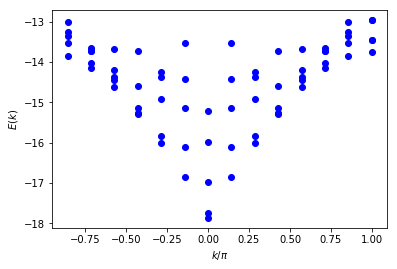

In [7]:
# part c)
H = ed_conserve.calc_H(14, 1., 1.)
plt.figure()
for qn in H:
    k = qn * 2/14
    E = scipy.sparse.linalg.eigsh(H[qn], k=5, which='SA', return_eigenvectors=False)
    plt.plot(k*np.ones(len(E)),np.real(E),'bo')
plt.xlabel('$k/\\pi$')
plt.ylabel('$E(k)$')
plt.show()


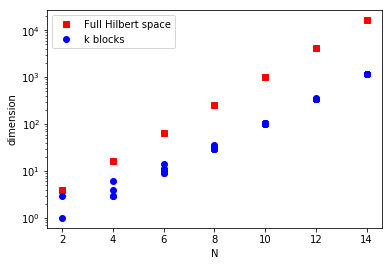

In [8]:
# part d)
plt.figure()
for N in range(2, 16, 2):
    basis, _ = ed_conserve.calc_basis(N)
    dims = [len(basis[qn]) for qn in basis]
    plt.plot([N], [np.sum(dims)], 'rs', label='total')
    plt.plot(N*np.ones(len(dims)), dims, 'bo', label='k')
plt.yscale('log')
plt.ylabel('dimension')
plt.xlabel('N')
plt.legend(['Full Hilbert space', 'k blocks'])  # only use the first two entries of the legend, with given strings
plt.show()

In [9]:
# part e)
def parity(s, N):
    return int((-1.)**(-N + ed_conserve.count_ones(s, N)))


def calc_basis(N):
    """Determine the (representatives of the) basis for each block.

    A block is detemined by the quantum numbers `qn`, here `(p, k)`.
    `basis` and `ind_in_basis` are dictionaries with `qn` as keys.
    For each block, `basis[qn]` contains all the representative spin configurations `sa`
    and periodicities `Ra` generating the state
    ``|a(k)> = 1/sqrt(Na) sum_l=0^{N-1} exp(i k l) T**l |sa>``

    `ind_in_basis[qn]` is a dictionary mapping from the representative spin configuration `sa`
    to the index within the list `basis[qn]`.
    """
    basis = dict()
    ind_in_basis = dict()
    for sa in range(2**N):
        p = parity(sa, N)
        for k in range(-N//2+1, N//2+1):
            qn = (p, k)
            Ra = ed_conserve.is_representative(sa, k, N)
            if Ra > 0:
                if qn not in basis:
                    basis[qn] = []
                    ind_in_basis[qn] = dict()
                ind_in_basis[qn][sa] = len(basis[qn])
                basis[qn].append((sa, Ra))
    return basis, ind_in_basis

def calc_H(N, J, g):
    """Determine the blocks of the Hamiltonian as scipy.sparse.csr_matrix."""
    print("Generating Hamiltonian ... ", end="", flush=True)
    basis, ind_in_basis = calc_basis(N)
    H = {}
    for qn in basis:
        M = len(basis[qn])
        H_block_data = []
        H_block_inds = []
        a = 0
        for sa, Ra in basis[qn]:
            H_block_data.append(-g * (-N + 2*ed_conserve.count_ones(sa, N)))
            H_block_inds.append((a, a))
            for i in range(N):
                sb, l = ed_conserve.get_representative(ed_conserve.flip(sa, i, N), N)
                if sb in ind_in_basis[qn]:
                    b = ind_in_basis[qn][sb]
                    Rb = basis[qn][b][1]
                    k = qn[1]*2*np.pi/Ra
                    H_block_data.append(-J*np.exp(-1j*k*l)*np.sqrt(Ra/Rb))
                    H_block_inds.append((b, a))
                # else: flipped state incompatible with the k value, |b(k)> is zero
            a += 1
        H_block_inds = np.array(H_block_inds)
        H_block_data = np.array(H_block_data)
        H_block = scipy.sparse.csr_matrix((H_block_data, (H_block_inds[:, 0], H_block_inds[:, 1])),
                                          shape=(M,M),dtype=np.complex)
        H[qn] = H_block
    print("done", flush=True)
    return H


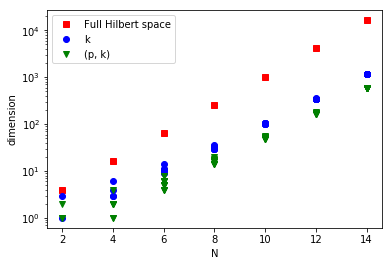

In [10]:
# part f)
plt.figure()
for N in range(2, 16, 2):
    basis, _ = ed_conserve.calc_basis(N)
    dims = [len(basis[qn]) for qn in basis]
    plt.plot([N], [np.sum(dims)], 'rs', label='S')
    plt.plot(N*np.ones(len(dims)), dims, 'bo', label='k')
    basis_s, _ = calc_basis(N)
    dims = [len(basis_s[qn]) for qn in basis_s]
    plt.plot(N*np.ones(len(dims)), dims, 'gv', label='k')
plt.yscale('log')
plt.ylabel('dimension')
plt.xlabel('N')
plt.legend(['Full Hilbert space', 'k', '(p, k)'])
plt.show()

Generating Hamiltonian ... done


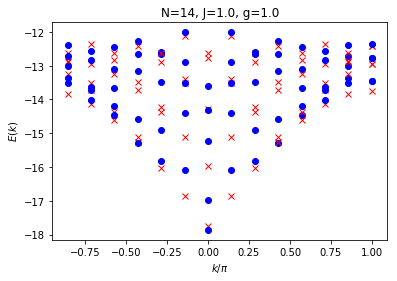

Generating Hamiltonian ... done


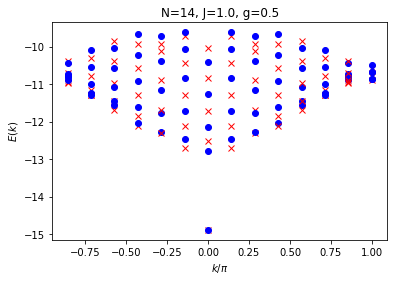

Generating Hamiltonian ... done


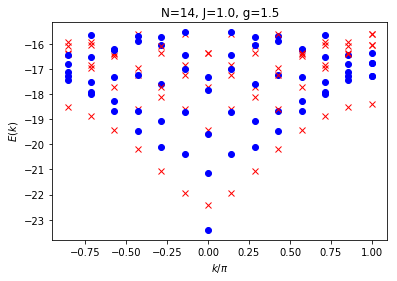

Generating Hamiltonian ... done


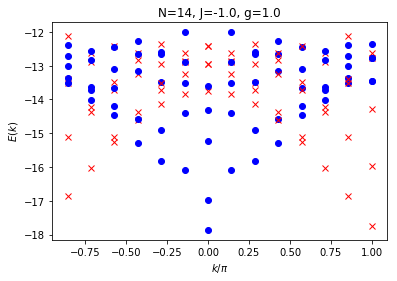

Generating Hamiltonian ... done


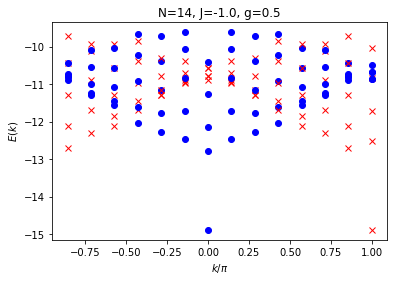

Generating Hamiltonian ... done


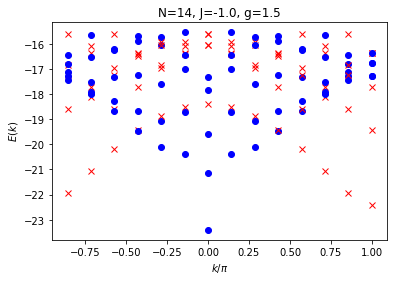

In [11]:
# part g)
N = 14
for J, g in [(1., 1.), (1., 0.5), (1., 1.5), (-1., 1.), (-1., 0.5), (-1., 1.5)]:
    H = calc_H(N, J, g)
    plt.figure()
    for qn in H:
        k = qn[1] * 2/14
        p = qn[0]
        E = scipy.sparse.linalg.eigsh(H[qn], k=5, which='SA', return_eigenvectors=False)
        style = 'bo' if p == 1. else 'rx'
        plt.plot(k*np.ones(len(E)),np.real(E), style)
        
    plt.xlabel('$k/\\pi$')
    plt.ylabel('$E(k)$')
    plt.title("N={N:d}, J={J:.1f}, g={g:0.1f}".format(N=N, J=J, g=g))
    plt.show()